## Has there been an observed RILE event in Obs record yet? And if not, how close did we get? 
By A. Jahn, CU Boulder, Oct 2024

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.ndimage.filters import uniform_filter1d


/glade/derecho/scratch/ajahn/tmp/ipykernel_71045/3478677091.py:6: DeprecationWarning: Please import `uniform_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import uniform_filter1d


In [2]:
#Convert monthly data array with one time dimension in datetime64 to array with year and month columns
def to_year_month(ds):
    year = ds.time.dt.year
    month = ds.time.dt.month

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return ds.set_index(time=("year", "month")).unstack("time")  


#Convert daily data array with one time dimension in datetime64 to array of year and julien day of the year in two columns
def to_year_dayofyear(ds):
    year = ds.time.dt.year
    dayofyear = ds.time.dt.dayofyear
    
    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time",dayofyear.data))

    # reshape the array to (..., "daofyear", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time")  
#Convert daily data array with one time dimension in datetime64 to array of year, month, and day of the month
def to_year_month_day(ds):
    year = ds.time.dt.year
    month = ds.time.dt.month
    day = ds.time.dt.day
    
    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), month=("time", month.data),day=("time",day.data))

    # reshape the array to (..., "day","month", "year")
    return ds.set_index(time=("year", "month","day")).unstack("time")  

In [3]:
data_path = '/glade/u/home/ajahn/CMIP6_daily_SIE_SIA/'

#Load Obs data 
daily_CDR = xr.open_dataset(data_path+'NSIDC_CDR_daily_v4_SIA_SIE_197901-202312_no_leap.nc')
daily_SIE=daily_CDR['CDR_SIE']
daily_SIA=daily_CDR['CDR_SIA']
daily_time=daily_CDR['time']
#There is some daily data missing, so need to set those to nan so it isn't detected as the minimum
daily_SIA[ daily_SIA==0 ] = np.nan
daily_SIE[ daily_SIE==0 ] = np.nan


obs_SIA_y_m_d=to_year_month_day(daily_SIA)
obs_SIA_y_m=obs_SIA_y_m_d.mean(axis=2)

obs_SIE_y_m_d=to_year_month_day(daily_SIE)
obs_SIE_y_m=obs_SIE_y_m_d.mean(axis=2)



In [4]:
SIE=obs_SIE_y_m.sel(year=slice('1979','2023'))

In [5]:
SIE.sel(month=9).sel(year=slice('2006','2007'))

<xarray.DataArray 'CDR_SIE' (year: 2)> Size: 16B
array([5.77225   , 4.21189583])
Coordinates:
  * year     (year) int64 16B 2006 2007
    month    int64 8B 9

## CALCULATE when RILE threshold conditions are reached

**Holland et al 2016:** "We identify an abrupt event when the derivative of the five-year running mean smoothed Septem- ber ice extent timeseries exceeds a loss of 0.5 million km2 per year, equivalent to a loss of 7% of the 2000 ensemble mean ice extent in a single year. The event length is determined by the time around the transition for which the derivative of the smoothed timeseries exceeds a loss of 0.15 million km2 per year."

**Auclair and Tremblay 2018:** "A rapid sea ice decline is defined as a period of at least 4 years for which the trend in the 5-year running mean minimum SIE is lower than −0.3 million km2 /year. We use the 5-year running mean to filter out the interannual variability and to identify tendencies in the sea ice cover on time scales of a few years to a decade." Note that this definition is slightly different than the one used by Holland et al. (2006). It emphasizes the total SIE loss in a given rapid decline event instead of the maximum rate of sea ice loss during the event.

After checking with Auclair, this is what they actually did in their code:
   - Compute the 5-year running mean of minimum SIE (5yrm_minSIE).
   - Compute the trend in the 5-year running mean of minimum SIE between two different years (every combinations possible)
   - Then there is a RILE when the trend is smaller or equal to -0.3 million km^2/year and when (year2-year1) is greater or equal to 4. So for some years during the RILE, the sea ice loss might be small in absolute value (not as much as -0.3 million km^2/year), but over the length of the RILE, the 4yr trend will be at least -0.3 million km^2/year. 

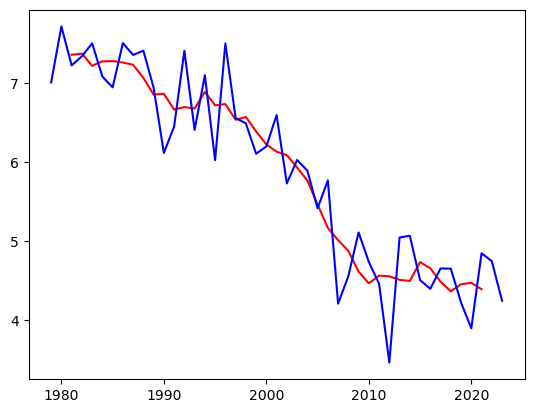

In [6]:
#Make 5yr running means 
Obs_SIE_5yr=SIE.sel(month=9)*0



Obs_SIE_5yr=SIE.sel(month=9).rolling(year=5,center='True').mean()
plt.plot(SIE['year'].values,Obs_SIE_5yr,'r',);
plt.plot(SIE['year'].values,SIE.sel(month=9).values,'b',);


### Find RILES as in Tremblay, make as RILE=1 if a RILE, RILE=0 if not a RILE 


In [7]:
#Returns binary RILE marker and trend over 4yr from 5yr running mean used to determine the RILE.
#Need to call with the 5yr running mean SIE Variable, start year index, end year index
def find_riles_obs(var,beg_year,end_year):
    
    RILE_o = var*0
    trend_o = var*0
    total = 0
    threshold=-0.3
    
    for yr1 in range(beg_year,end_year-3):
        for yr2 in range(yr1+4,end_year): 
            #yr2=yr1+3
            trend  = (var[yr2] - var[yr1]) / (yr2-yr1)
            rmask  = xr.where(trend <= threshold, 1,0)
            nriles = rmask.sum().values
            total +=nriles
            print(f"yr1={yr1} yr2={yr2} n_rile={nriles} total={total}",end="\r")
            if(nriles>0):
                for rile_yr in range(yr1, yr2):
                   RILE_o[rile_yr] = xr.where(rmask>0,1,RILE_o[rile_yr])
            trend_o[yr2] =trend
    return RILE_o,trend_o



In [8]:
#1 yr trends
def find_obs_trends(var,beg_year,end_year):
    trend_1yr = var*0
    total = 0
    
    for yr1 in range(beg_year,end_year-3):
        #for yr2 in range(yr1+4,end_year): 
            yr2=yr1+1
            trend  = (var[yr2] - var[yr1]) / (yr2-yr1)
            trend_1yr[yr2] =trend
    return trend_1yr


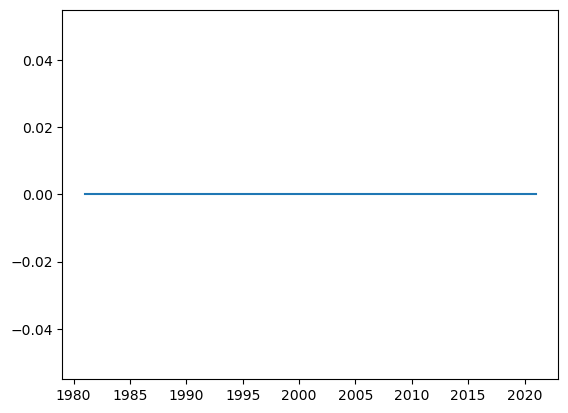

In [9]:
#For Obs

RILE_ob= find_riles_obs(Obs_SIE_5yr,0,44) 
RILE=RILE_ob[0]

#No RILE YET observed
time=np.arange(1979,2024)
plt.plot(time,RILE)

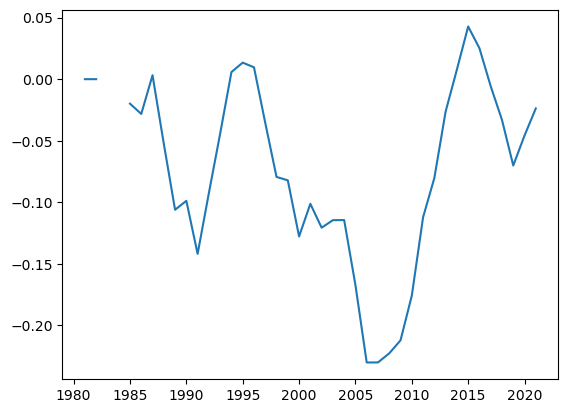

In [10]:
trend_4yr_ob=RILE_ob[1]

plt.plot(time,trend_4yr_ob)

In [11]:
trend_4yr_ob.sel(year=slice('2006','2009'))

<xarray.DataArray 'CDR_SIE' (year: 4)> Size: 32B
array([-0.23003021, -0.22999167, -0.22260417, -0.21203333])
Coordinates:
  * year     (year) int64 32B 2006 2007 2008 2009
    month    int64 8B 9

In [12]:
#Playing with modifying obs record to see if difference sequence of obs events would have qualified as a RILE. 
#Answer is yes

#1. artificial timeseries with two 2006-2007 ice-losses in a row 
#2006 SIE 5.77225
#2007 SIE 4.21189583
#1 Artificial timeseries
print(SIE[29].sel(month=9))
a=4.21189583-5.77225
print('2006 to 2007 SIE drop in Sept monthly mean',a)

print(SIE.sel(month=9))
SIE['year'][29]

<xarray.DataArray 'CDR_SIE' ()> Size: 8B
array(4.55902083)
Coordinates:
    year     int64 8B 2008
    month    int64 8B 9
2006 to 2007 SIE drop in Sept monthly mean -1.56035417
<xarray.DataArray 'CDR_SIE' (year: 45)> Size: 360B
array([7.011     , 7.71945833, 7.2266875 , 7.34195833, 7.50666667,
       7.08491667, 6.94929167, 7.50870833, 7.35854167, 7.4139375 ,
       6.9430625 , 6.11922917, 6.452875  , 7.410875  , 6.41039583,
       7.10245833, 6.02808333, 7.50370833, 6.56047917, 6.49372917,
       6.108875  , 6.20133333, 6.59829167, 5.73264583, 6.02941667,
       5.894875  , 5.41791667, 5.77225   , 4.21189583, 4.55902083,
       5.11222917, 4.739625  , 4.46291667, 3.46689583, 5.04891667,
       5.07127083, 4.510125  , 4.39908333, 4.657     , 4.6545    ,
       4.22460417, 3.8993125 , 4.84895833, 4.74920833, 4.24822917])
Coordinates:
  * year     (year) int64 360B 1979 1980 1981 1982 1983 ... 2020 2021 2022 2023
    month    int64 8B 9


<xarray.DataArray 'year' ()> Size: 8B
array(2008)
Coordinates:
    year     int64 8B 2008

In [13]:
SIE_Sept_art=SIE.sel(month=9)
SIE_Sept_art[29]=SIE_Sept_art[28]+a #year 2008
SIE_Sept_art_5yr=SIE_Sept_art.rolling(year=5,center='True').mean()

RILE_ob_art= find_riles_obs(SIE_Sept_art_5yr,0,44) 


<xarray.DataArray 'CDR_SIE' (year: 4)> Size: 32B
array([-0.32540417, -0.32536563, -0.31797813, -0.30740729])
Coordinates:
  * year     (year) int64 32B 2006 2007 2008 2009
    month    int64 8B 9

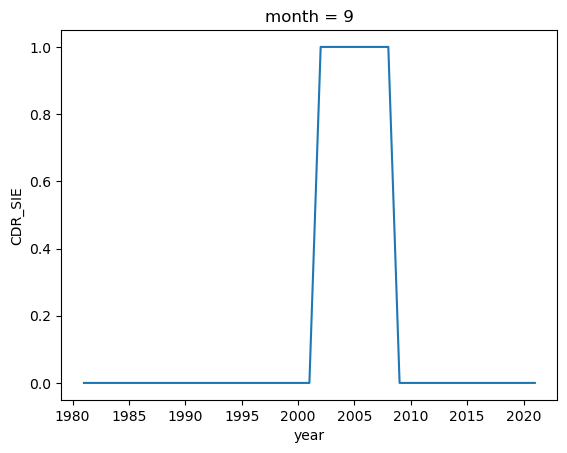

In [18]:
RILE_ob_art[0].plot()
#Now there is a RILE
RILE_ob_art[1].sel(year=slice('2006','2009'))

In [19]:
#second articficial timeseries, with 2011-2012 drop in 2009 added 
daily_CDR = xr.open_dataset(data_path+'NSIDC_CDR_daily_v4_SIA_SIE_197901-202312_no_leap.nc')
daily_SIE=daily_CDR['CDR_SIE']
daily_SIA[ daily_SIA==0 ] = np.nan
obs_SIE_y_m_d=to_year_month_day(daily_SIE)
obs_SIE_y_m=obs_SIE_y_m_d.mean(axis=2)
SIE=obs_SIE_y_m.sel(year=slice('1979','2023'))

SIE_Sept_art2=SIE.sel(month=9)


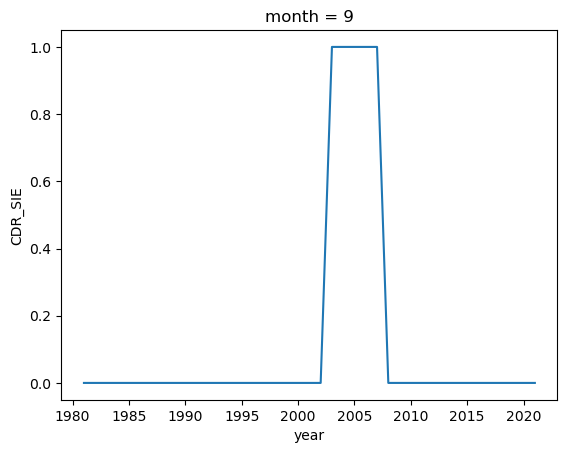

In [20]:

c=3.46689583-4.46291667 #2012 SIA min minus 2011 SIA min, gives 2011-2012 drop
SIE_Sept_art2[30]=SIE_Sept_art2[29]+c #make year 2009 lower, by replacing the 2008-2009 drop with the 2011-2012 drop 
SIE_Sept_art2_5yr=SIE_Sept_art2.rolling(year=5,center='True').mean()
RILE_ob_art2= find_riles_obs(SIE_Sept_art2_5yr,0,44) 
RILE_ob_art2[0].plot()


<xarray.DataArray 'CDR_SIE' (year: 4)> Size: 32B
array([-0.23003021, -0.30745313, -0.30006563, -0.28949479])
Coordinates:
  * year     (year) int64 32B 2006 2007 2008 2009
    month    int64 8B 9

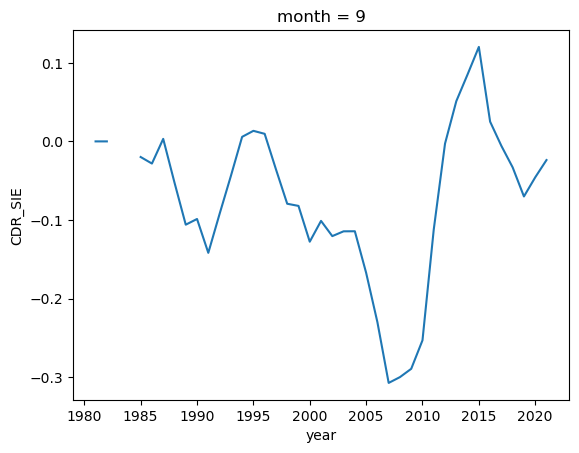

In [21]:
#Average trend over 4yr in the 5yr running mean artificial data with a 2011-2012 drop after the 2two 2006 to 2007 drops in a row
RILE_ob_art2[1].plot()
#4yr Trends
RILE_ob_art2[1].sel(year=slice('2006','2009'))

Artificial trend 1= <xarray.DataArray 'CDR_SIE' ()> Size: 8B
array(-0.32540417)
Coordinates:
    month    int64 8B 9
Artificial trend 2= <xarray.DataArray 'CDR_SIE' ()> Size: 8B
array(-0.30745313)
Coordinates:
    month    int64 8B 9
Original= <xarray.DataArray 'CDR_SIE' ()> Size: 8B
array(-0.23003021)
Coordinates:
    month    int64 8B 9


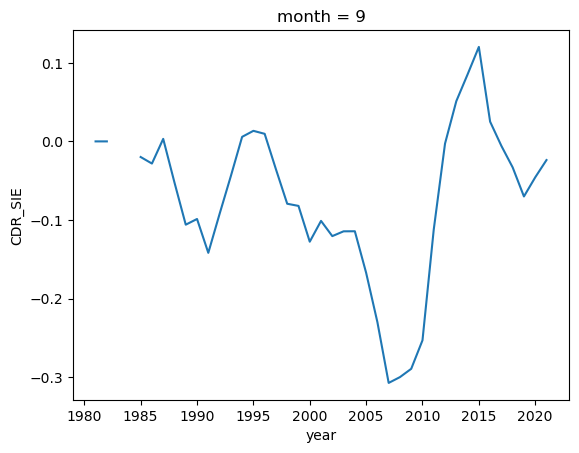

In [22]:
RILE_ob_art2[1].plot()
#TRends
print('Artificial trend 1=',RILE_ob_art[1].sel(year=slice('2006','2009')).min())
print('Artificial trend 2=',RILE_ob_art2[1].sel(year=slice('2006','2009')).min())

print('Original=',RILE_ob[1].sel(year=slice('2006','2009')).min())
#print(RILE_ob_art2[1])

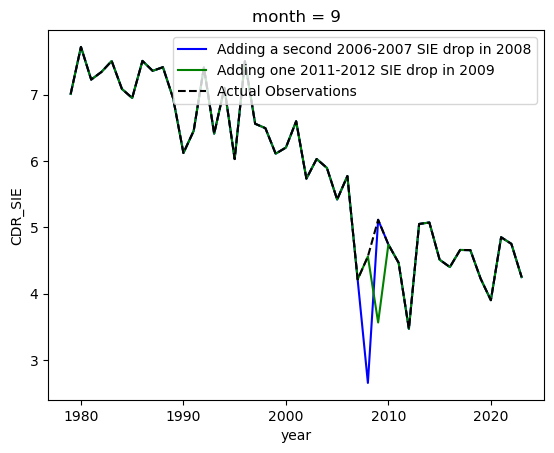

In [24]:
daily_CDR = xr.open_dataset(data_path+'NSIDC_CDR_daily_v4_SIA_SIE_197901-202312_no_leap.nc')
daily_SIE=daily_CDR['CDR_SIE']
daily_SIA[ daily_SIA==0 ] = np.nan
obs_SIE_y_m_d=to_year_month_day(daily_SIE)
obs_SIE_y_m=obs_SIE_y_m_d.mean(axis=2)
SIE=obs_SIE_y_m.sel(year=slice('1979','2023'))

SIE_Sept_art.plot(color='b',label='Adding a second 2006-2007 SIE drop in 2008')
SIE_Sept_art2.plot(color='g',label='Adding one 2011-2012 SIE drop in 2009')

SIE.sel(month=9).plot(color='k',linestyle='--',label='Actual Observations')
plt.legend(loc='upper right')
trends_obs= find_obs_trends(SIE.sel(month=9),0,44) 
